In [1]:
import sys
import os
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Get the current working directory
# Get project root (folder above 'notebooks')
project_root = os.path.dirname(os.getcwd())

# Path to scripts folder
scripts_path = os.path.join(project_root, "scripts")
analysis_path = os.path.join(project_root, "analysis")

# Add to sys.path
sys.path.append(project_root)
sys.path.append(scripts_path)
sys.path.append(analysis_path)

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from utils import drop_unusable_column,convert_object_to_numeric,impute_missing_values,create_vehicle_age_feature, parse_date_columns

In [3]:
from analysis import get_column_types,plot_numerical_distributions,plot_categorical_distributions,analyze_categorical_geography,analyze_numerical_geography,plot_loss_ratio_by_province,plot_box_plots_for_outliers_separate

In [4]:
df = pd.read_csv(
    '../data/MachineLearningRating_v3.txt',
    sep='|',
    encoding='utf-8',
    engine='python'
)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      854137 non-null   object 
 9   AccountType               959866 non-null   object 
 10  MaritalStatus             991839 non-null   object 
 11  Gender                    990562 non-null   object 
 12  Country                   1000098 non-null  object 
 13  Province                  1

#### ○ Data Summarization:

In [5]:
df_clean = drop_unusable_column(df)
df_clean = convert_object_to_numeric(df_clean)
df_clean = impute_missing_values(df_clean)
df_clean = create_vehicle_age_feature(df_clean)

Dropped 'NumberOfVehiclesInFleet' (0 non-nulls).
Cleaned and converted 'ExcessSelected' to numeric.
Cleaned and converted 'CapitalOutstanding' to numeric.
Imputed missing values in 'mmcode' with median: 60,058,415.00
Imputed missing values in 'Cylinders' with median: 4.00
Imputed missing values in 'cubiccapacity' with median: 2,694.00
Imputed missing values in 'kilowatts' with median: 111.00
Imputed missing values in 'NumberOfDoors' with median: 4.00
Imputed missing values in 'CustomValueEstimate' with 0.
Created 'VehicleAge' feature.


In [7]:


# ---  Final Robust Calculation of Variability Statistics ---

# Define the final list of numerical columns for analysis
numerical_features = [
    'RegistrationYear', 'Cylinders', 'cubiccapacity', 'kilowatts', 'NumberOfDoors',
    'CustomValueEstimate', 'CapitalOutstanding', 'SumInsured',
    'CalculatedPremiumPerTerm', 'ExcessSelected', 'TotalPremium',
    'TotalClaims', 'VehicleAge'
]

# Ensure only existing columns are included
numerical_features = [col for col in numerical_features if col in df_clean.columns]

# 1. Use .describe() for standard metrics
variability_stats_desc = df_clean[numerical_features].describe().T

# 2. Calculate Variance explicitly and add it
variance_series = df_clean[numerical_features].var()
variability_stats_desc['var'] = variance_series

# 3. Calculate the custom variability metrics (Range, IQR, CV)
variability_stats_desc['range'] = variability_stats_desc['max'] - variability_stats_desc['min']
variability_stats_desc['iqr'] = variability_stats_desc['75%'] - variability_stats_desc['25%']

# 4. Calculate CV (Coefficient of Variation)
variability_stats_desc['cv (%)'] = np.where(
    variability_stats_desc['mean'] != 0,
    (variability_stats_desc['std'] / variability_stats_desc['mean']) * 100,
    0
)

# 5. Select the final report columns (Now 'var' is guaranteed to be in the index)
variability_report = variability_stats_desc[[
    'count', 'mean', 'std', 'var', 'range', 'iqr', 'cv (%)'
]]

# Format the output for clarity
pd.options.display.float_format = '{:,.2f}'.format
print("\n## 📊 Variability Statistics Report for Numerical Features")
print(variability_report)


## 📊 Variability Statistics Report for Numerical Features
                                count           mean            std  \
RegistrationYear         1,000,098.00       2,010.23           3.26   
Cylinders                1,000,098.00           4.05           0.29   
cubiccapacity            1,000,098.00       2,466.87         442.71   
kilowatts                1,000,098.00          97.22          19.39   
NumberOfDoors            1,000,098.00           4.02           0.47   
CustomValueEstimate      1,000,098.00      49,714.82     281,048.10   
CapitalOutstanding       1,000,096.00      61,610.22     515,541.65   
SumInsured               1,000,098.00     604,172.73   1,508,331.84   
CalculatedPremiumPerTerm 1,000,098.00         117.88         399.70   
ExcessSelected             111,471.00 949,372,393.51 970,907,257.32   
TotalPremium             1,000,098.00          61.91         230.28   
TotalClaims              1,000,098.00          64.86       2,384.07   
VehicleAge        

In [40]:
df_clean[numerical_features].describe()

,RegistrationYear,Cylinders,cubiccapacity,kilowatts,NumberOfDoors,CustomValueEstimate,CapitalOutstanding,SumInsured,CalculatedPremiumPerTerm,ExcessSelected,TotalPremium,TotalClaims,VehicleAge
count,"1,000,098.00","1,000,098.00","1,000,098.00","1,000,098.00","1,000,098.00","1,000,098.00","1,000,096.00","1,000,098.00","1,000,098.00","111,471.00","1,000,098.00","1,000,098.00","1,000,098.00"
mean,"2,010.23",4.05,"2,466.87",97.22,4.02,"49,714.82","61,610.22","604,172.73",117.88,"949,372,393.51",61.91,64.86,4.53
std,3.26,0.29,442.71,19.39,0.47,"281,048.10","515,541.65","1,508,331.84",399.70,"970,907,257.32",230.28,"2,384.07",3.28
min,"1,987.00",0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,250.00,-782.58,"-12,002.41",0.00
25%,"2,008.00",4.00,"2,237.00",75.00,4.00,0.00,0.00,"5,000.00",3.22,"1,000,003,000.00",0.00,0.00,2.00
50%,"2,011.00",4.00,"2,694.00",111.00,4.00,0.00,0.00,"7,500.00",8.44,"1,000,005,000.00",2.18,0.00,4.00
75%,"2,013.00",4.00,"2,694.00",111.00,4.00,0.00,0.00,"250,000.00",90.00,"1,000,005,000.00",21.93,0.00,7.00
max,"2,015.00",10.00,"12,880.00",309.00,6.00,"26,550,000.00","28,570,000.00","12,636,200.00","74,422.17","10,000,010,000.00","65,282.60","393,092.11",28.00


##### converte data value to date time type

In [8]:
df_clean = parse_date_columns(df_clean)

--- Date Parsing ---
✅ Successfully converted 'TransactionMonth' to datetime.
✅ Successfully converted 'VehicleIntroDate' to datetime.


D:\10Academy\week_3\InsuranceRiskAnalyticsPredictive_week3\scripts\utils.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


In [25]:
df_clean['LegalType'].value_counts()

LegalType
Individual           911929
Private company       83891
Close Corporation      2459
Public company         1295
Partnership             331
Sole proprieter         193
Name: count, dtype: int64

###  Univariate Analysis:
##### Distribution of Variables: Plot histograms for numerical columns and bar charts for categorical columns to understand distributions..



## 📈 Histograms (Numerical Variables)


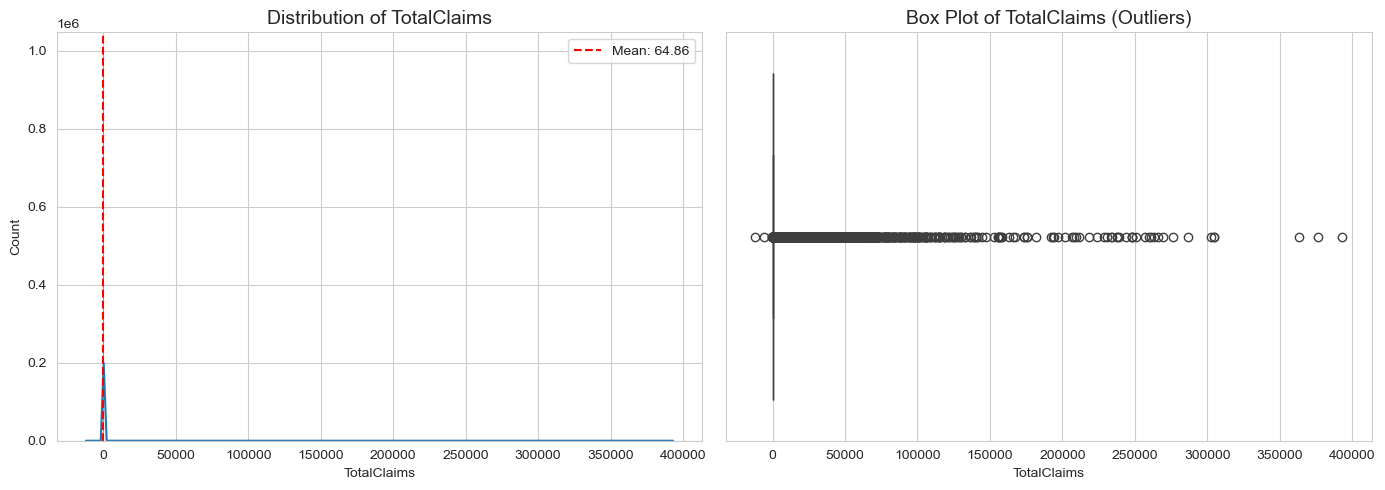

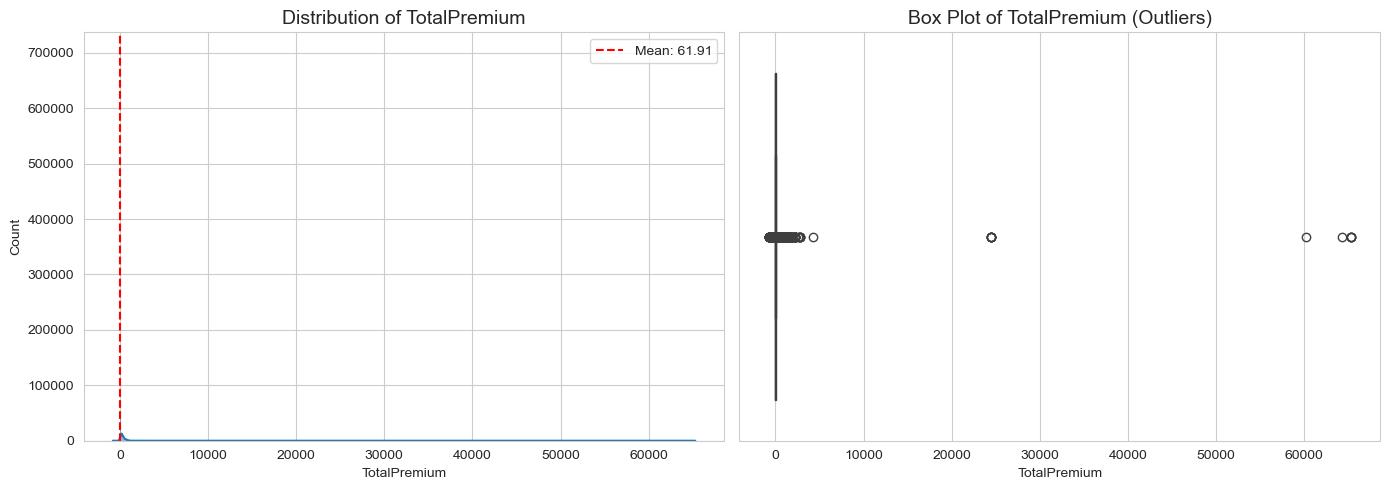

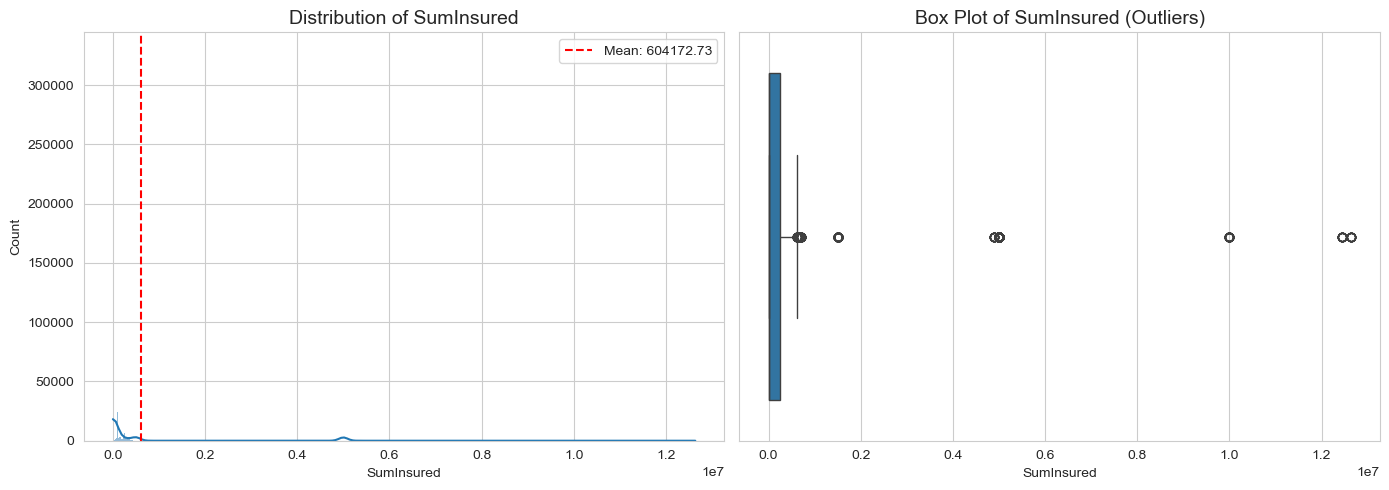

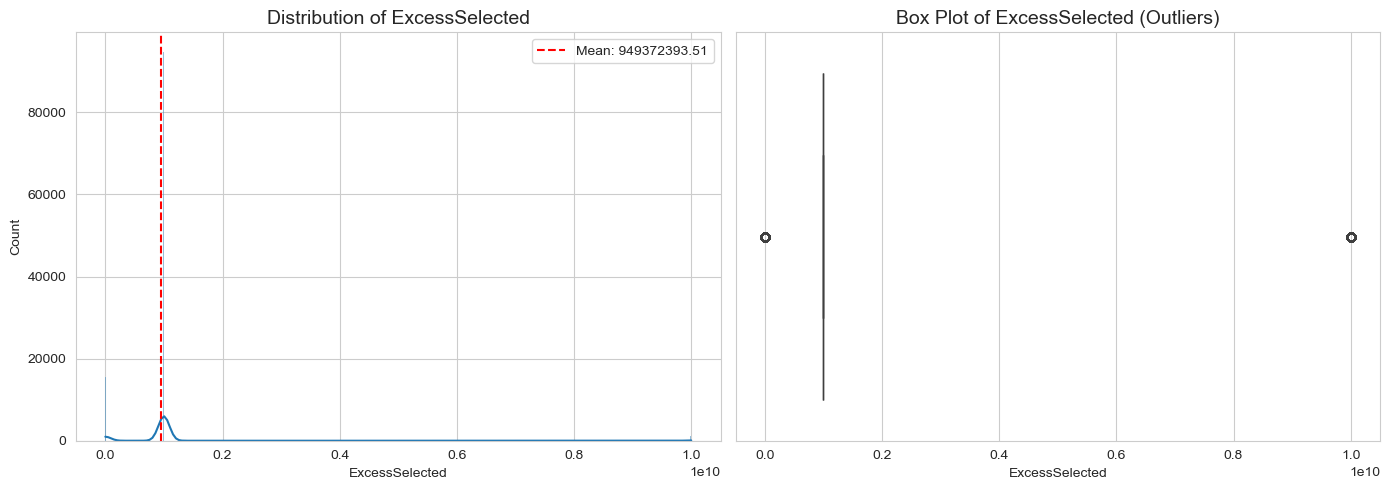

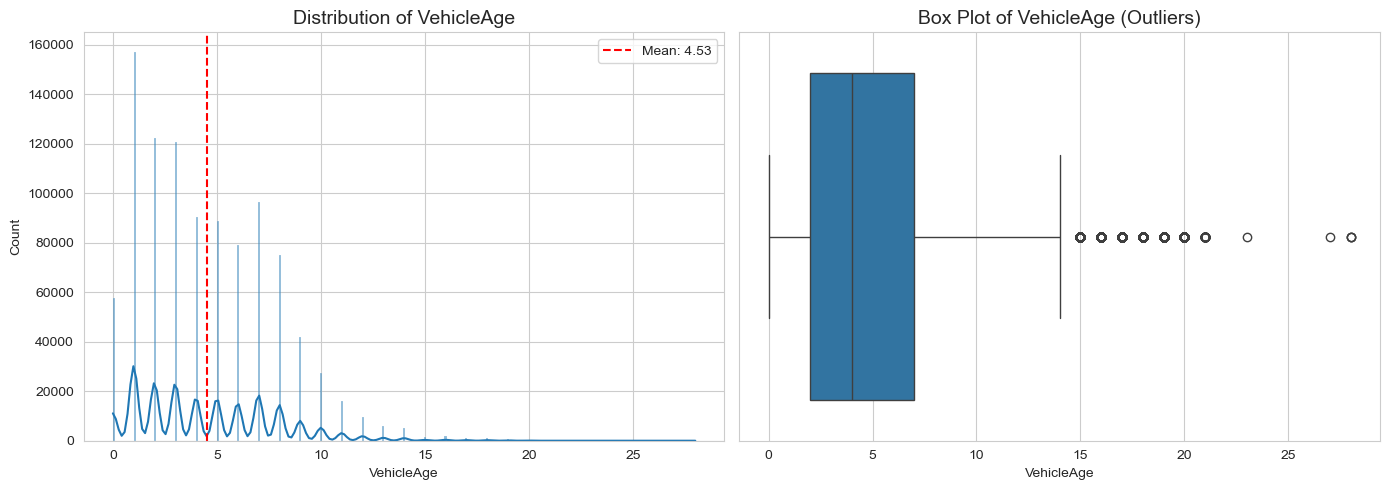


## 📊 Bar Charts (Categorical Variables)


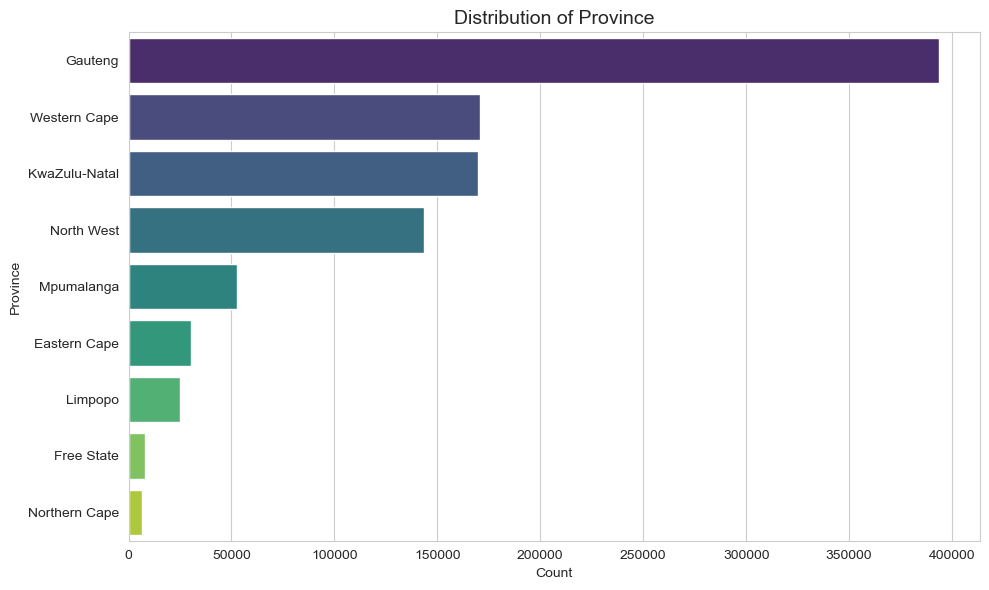

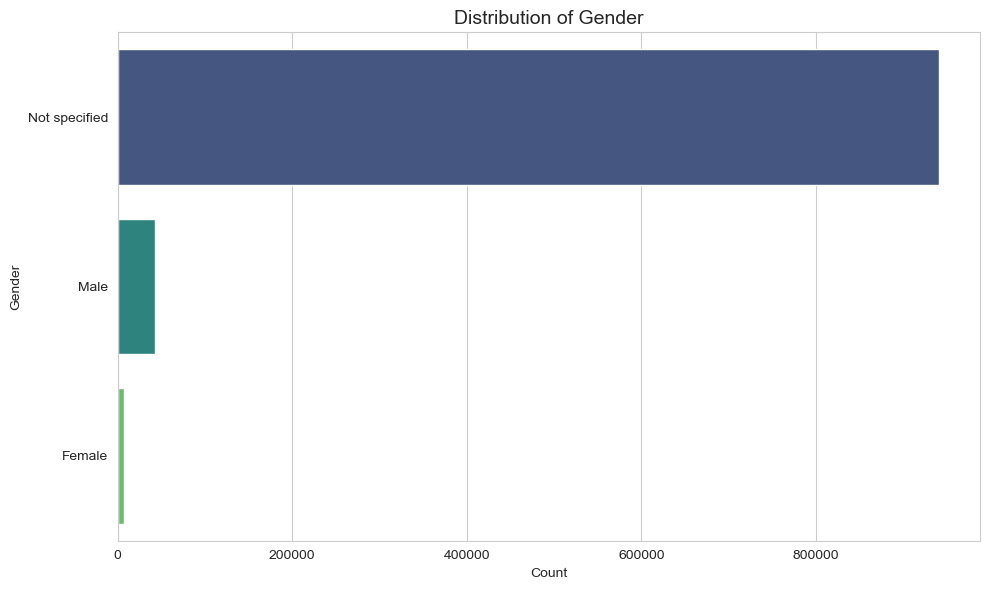

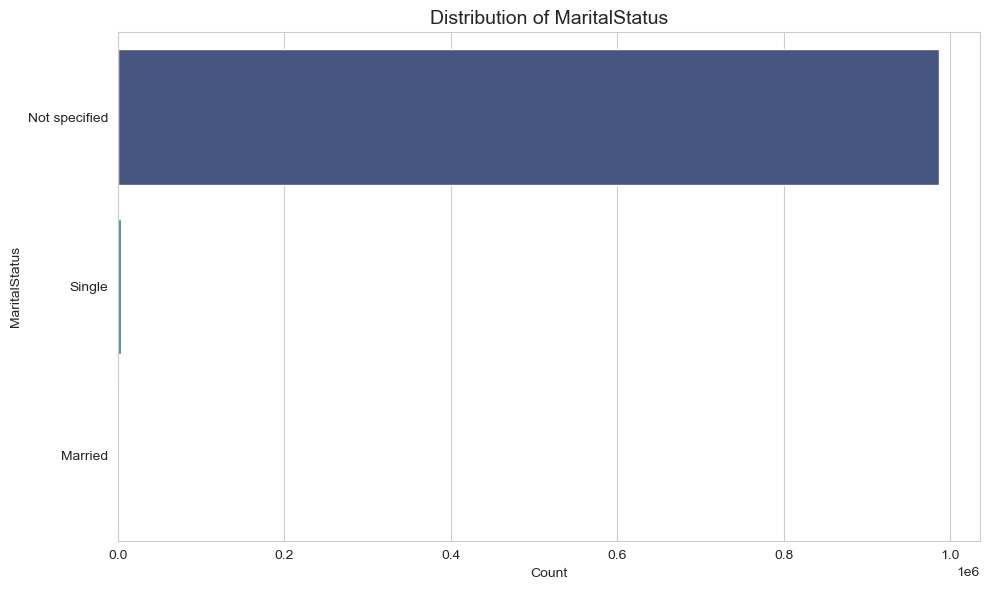

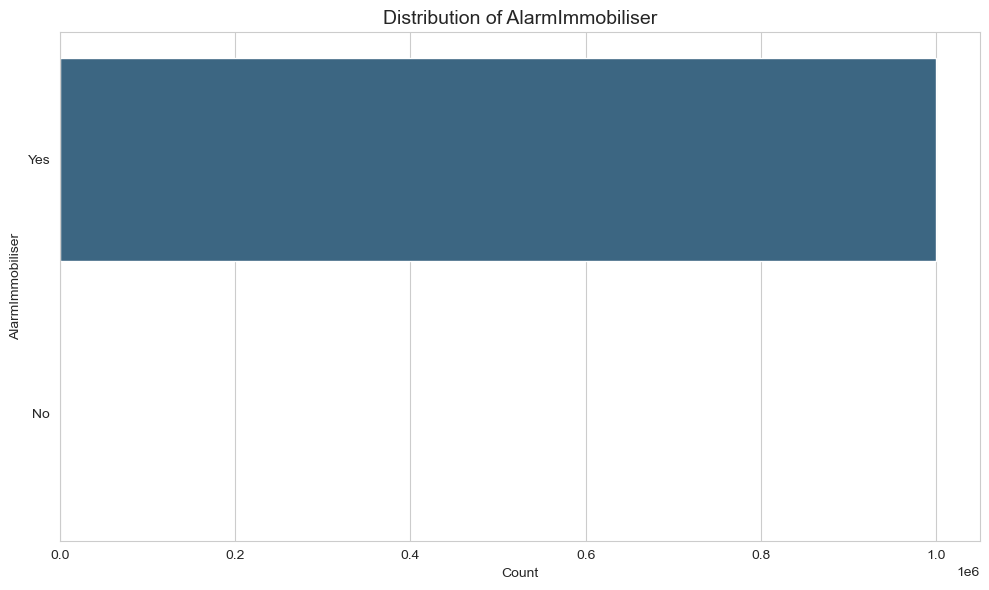

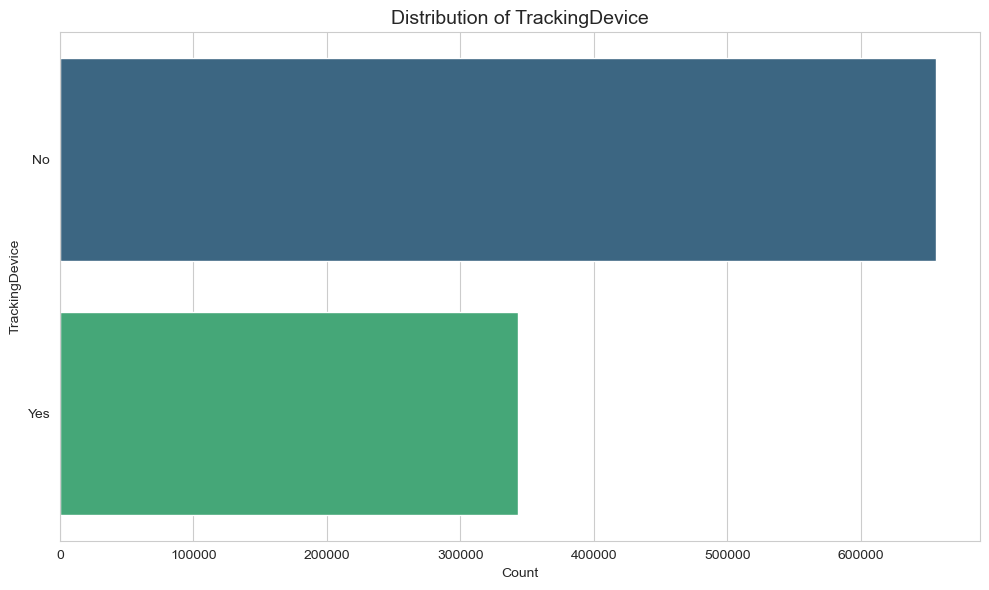

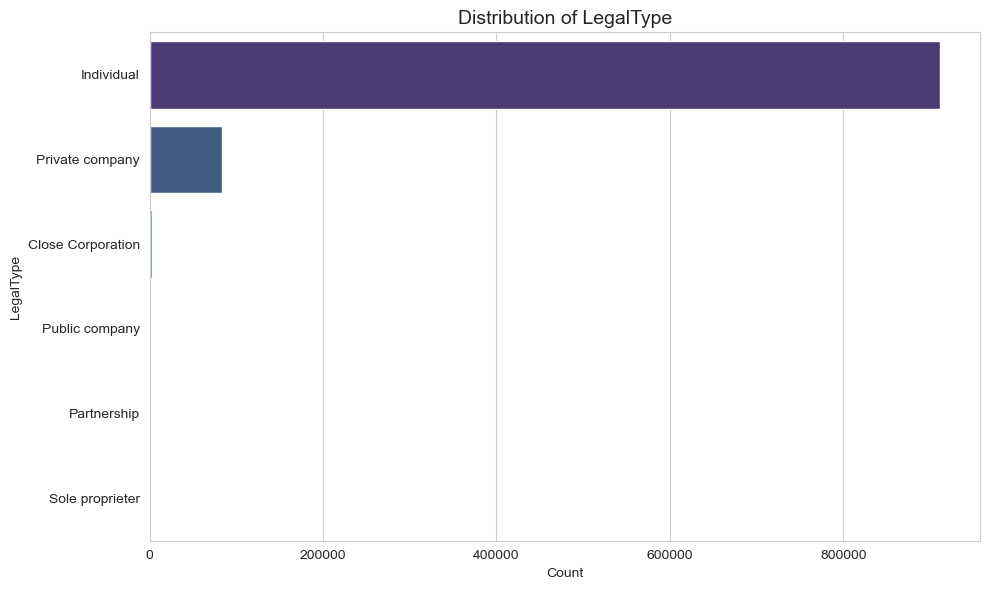

In [28]:
 numerical_features, categorical_features = get_column_types(df_clean)

 plot_numerical_distributions(df_clean, numerical_features)
 plot_categorical_distributions(df_clean, categorical_features)

### Bivariate or Multivariate Analysis:
##### Correlations and Associations: Explore relationships between the monthly changes TotalPremium and TotalClaims as a function of ZipCode, using scatter plots and correlation matrices.


##### Calculate Monthly Sums (Aggregation)

In [30]:
# Group by ZipCode and Month, then sum the total premium and claims
monthly_data = df_clean.groupby(['PostalCode', 'TransactionMonth']).agg(
    MonthlyPremium=('TotalPremium', 'sum'),
    MonthlyClaims=('TotalClaims', 'sum')
).reset_index()

# Ensure TransactionMonth is in datetime format if it wasn't done earlier
monthly_data['TransactionMonth'] = pd.to_datetime(monthly_data['TransactionMonth'])

##### Calculate Monthly Changes (Lagged Features)

In [31]:
# Sort data to ensure correct lagging for time series calculation
monthly_data = monthly_data.sort_values(by=['PostalCode', 'TransactionMonth'])

# Calculate the monthly percentage change for Premium and Claims
# The 'groupby' ensures the change calculation resets for each new ZipCode
monthly_data['Premium_Change'] = monthly_data.groupby('PostalCode')['MonthlyPremium'].pct_change()
monthly_data['Claims_Change'] = monthly_data.groupby('PostalCode')['MonthlyClaims'].pct_change()

# Drop the first month of data for each ZipCode, as pct_change results in NaN
monthly_changes = monthly_data.dropna(subset=['Premium_Change', 'Claims_Change']).copy()

# Filter out extreme outliers that can result from pct_change when the denominator is near zero.
# Example: Limit changes to a plausible range (e.g., -500% to 500%)
monthly_changes = monthly_changes[
    (monthly_changes['Premium_Change'].between(-5, 5)) & 
    (monthly_changes['Claims_Change'].between(-5, 5))
]

##### Calculating Correlation per ZipCode

In [32]:
# Calculate the correlation for each ZipCode
zipcode_correlations = monthly_changes.groupby('PostalCode').apply(
    lambda x: x['Premium_Change'].corr(x['Claims_Change'])
).reset_index(name='Claim_Premium_Correlation')

# Filter for ZipCodes that have enough months of data to make correlation meaningful (e.g., > 10 months)
# Note: You'd need to add a count column during the initial aggregation (Step A) to do this filtering accurately.
# For simplicity here, we proceed with all calculated correlations.

C:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\numpy\lib\_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\numpy\lib\_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\hp\miniconda3\envs\jupyter_env\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


##### Exploring the Correlation Distribution

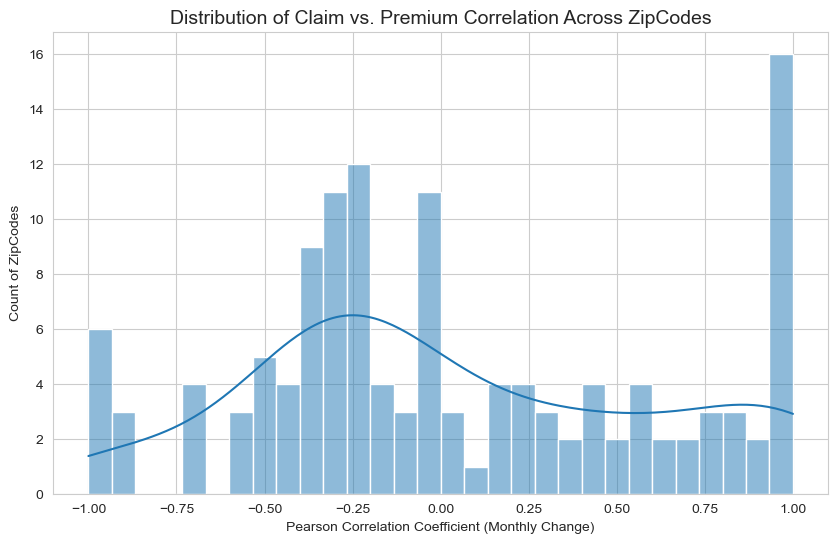

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(zipcode_correlations['Claim_Premium_Correlation'].dropna(), kde=True, bins=30)
plt.title('Distribution of Claim vs. Premium Correlation Across ZipCodes', fontsize=14)
plt.xlabel('Pearson Correlation Coefficient (Monthly Change)')
plt.ylabel('Count of ZipCodes')
plt.show()

##### Scatter Plot Visualization (Selected ZipCodes)

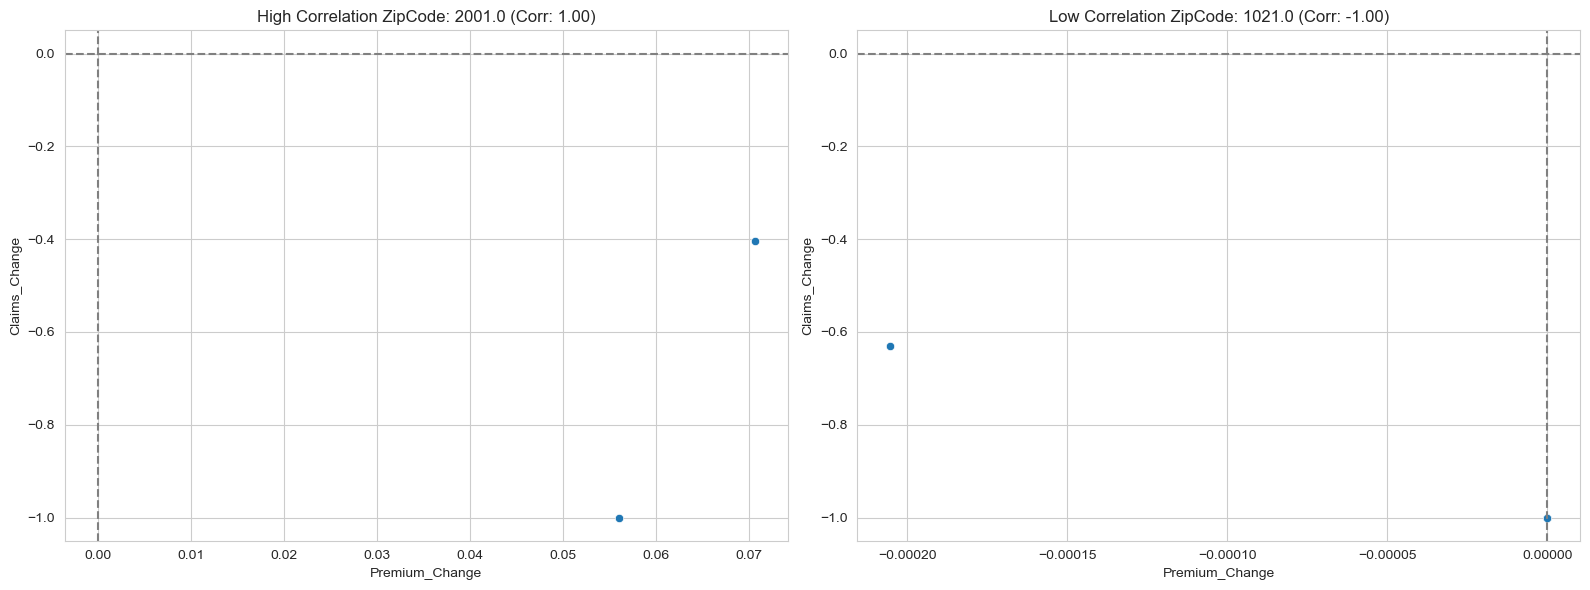

In [35]:
# 1. Identify Example ZipCodes (replace with actual values from your results)
# Example: High Correlation ZipCode
high_corr_zip = zipcode_correlations.sort_values('Claim_Premium_Correlation', ascending=False).iloc[0]['PostalCode']
# Example: Low Correlation ZipCode
low_corr_zip = zipcode_correlations.sort_values('Claim_Premium_Correlation', ascending=True).iloc[0]['PostalCode']

# 2. Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# High Correlation Plot
sns.scatterplot(
    data=monthly_changes[monthly_changes['PostalCode'] == high_corr_zip],
    x='Premium_Change', y='Claims_Change', ax=axes[0]
)
axes[0].set_title(f'High Correlation ZipCode: {high_corr_zip} (Corr: {zipcode_correlations[zipcode_correlations["PostalCode"] == high_corr_zip]["Claim_Premium_Correlation"].iloc[0]:.2f})')
axes[0].axhline(0, color='grey', linestyle='--')
axes[0].axvline(0, color='grey', linestyle='--')

# Low Correlation Plot
sns.scatterplot(
    data=monthly_changes[monthly_changes['PostalCode'] == low_corr_zip],
    x='Premium_Change', y='Claims_Change', ax=axes[1]
)
axes[1].set_title(f'Low Correlation ZipCode: {low_corr_zip} (Corr: {zipcode_correlations[zipcode_correlations["PostalCode"] == low_corr_zip]["Claim_Premium_Correlation"].iloc[0]:.2f})')
axes[1].axhline(0, color='grey', linestyle='--')
axes[1].axvline(0, color='grey', linestyle='--')

plt.tight_layout()
plt.show()

###  Data Comparison
####  Trends Over Geography: Compare the change in insurance cover type, premium, auto make, etc.


#### Calculating Proportions per Province
##### The best way to see the distribution of categorical features is by calculating the proportion (or percentage) of each category within each province.


--- Analyzing Categorical Trends Across Provinces ---


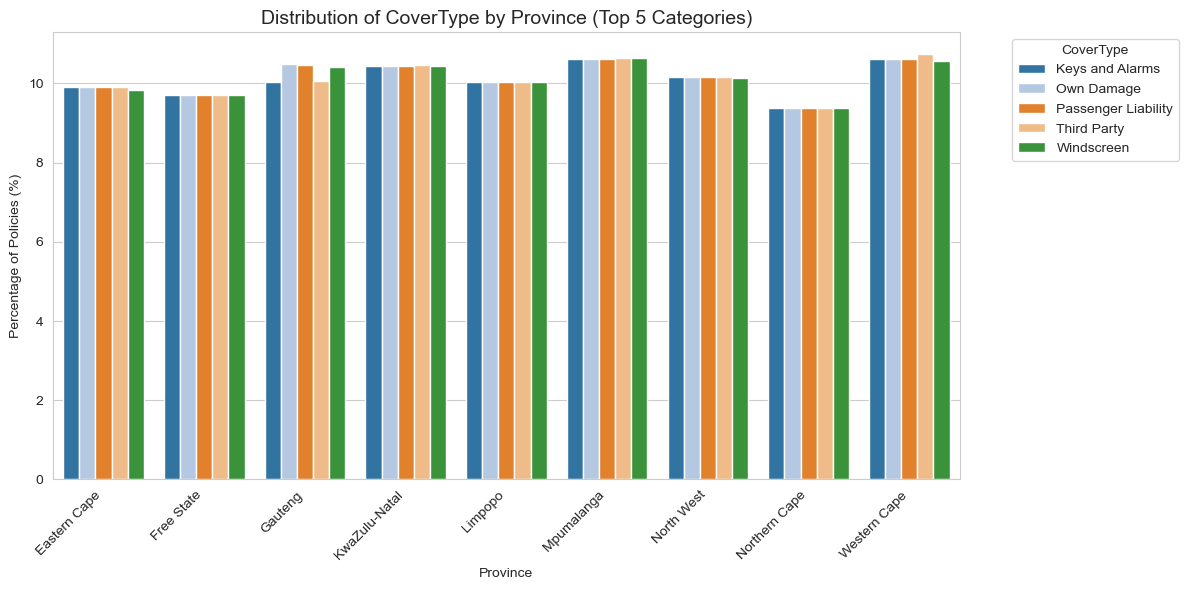

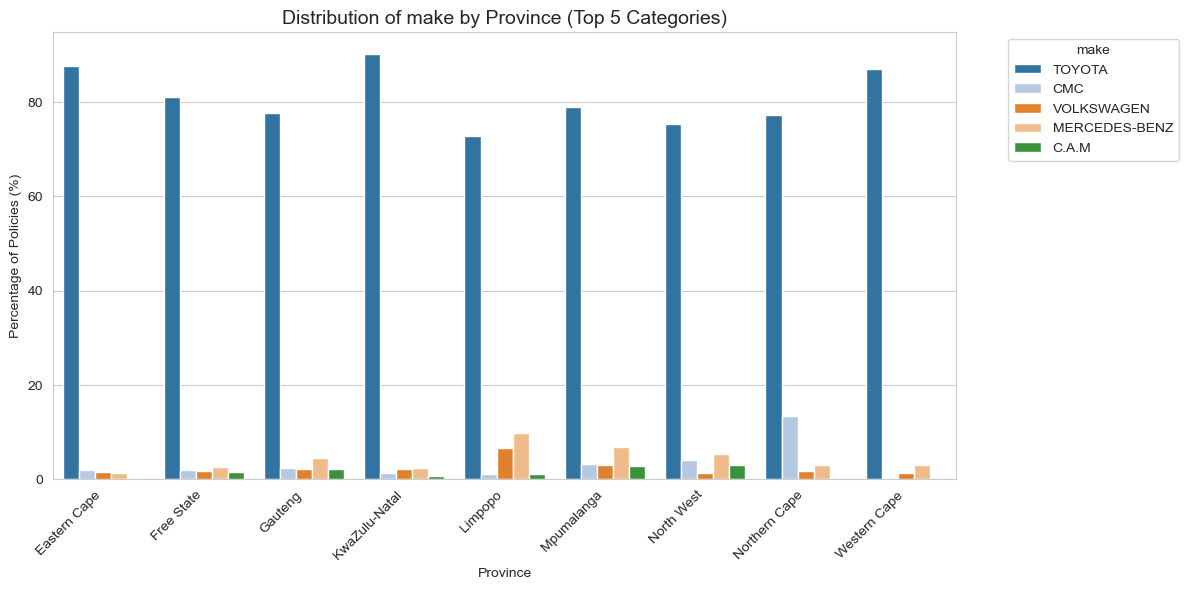

In [6]:
# Columns to compare for distribution:
categorical_comparison_cols = ['CoverType', 'make']
analyze_categorical_geography(df_clean, categorical_comparison_cols)

### Calculating Mean Premium per Province
##### Calculate the mean of key financial metrics, like TotalPremium, grouped by Province.


--- Analyzing Numerical Trends Across Provinces ---


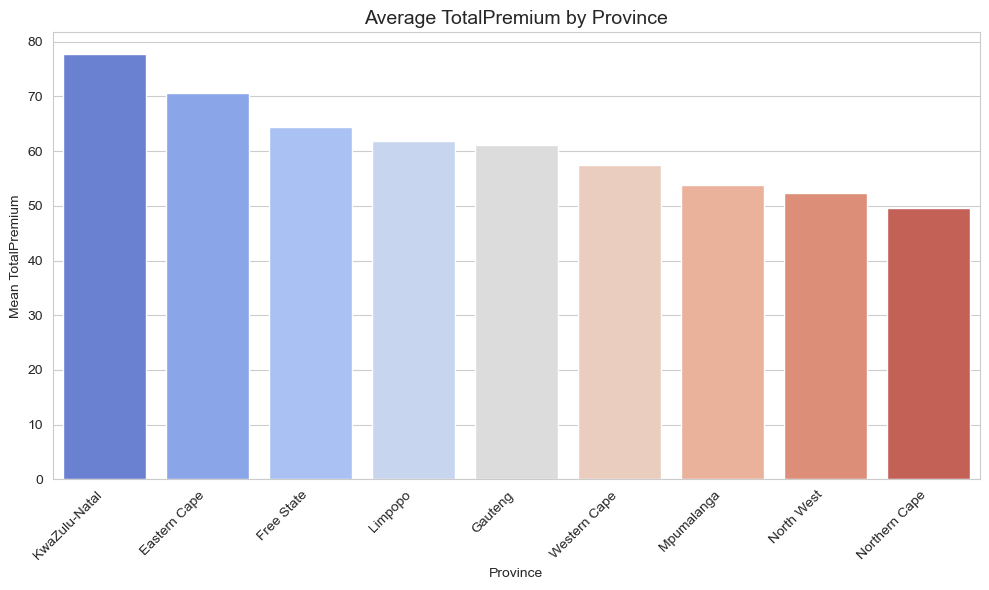

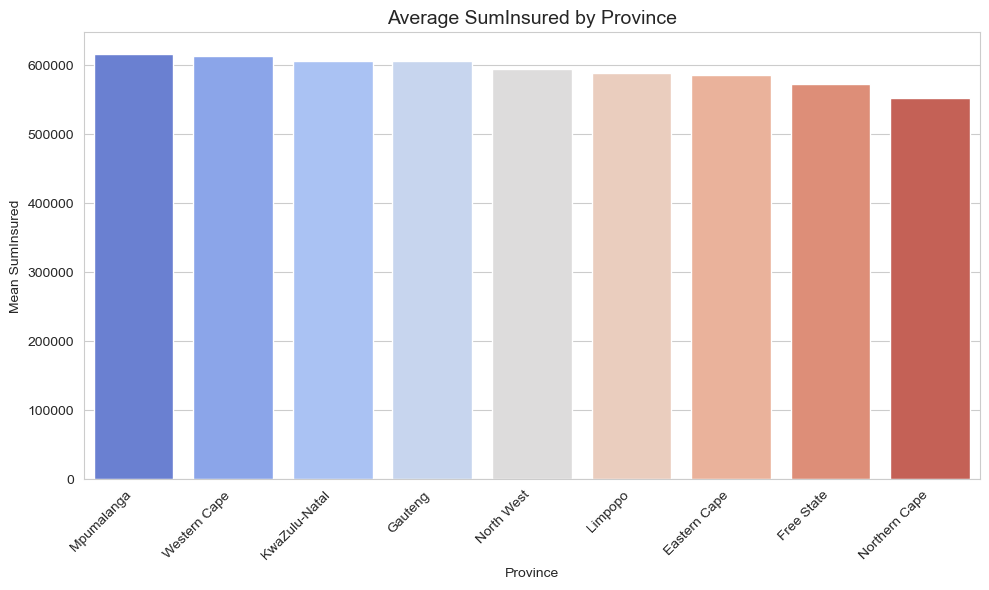

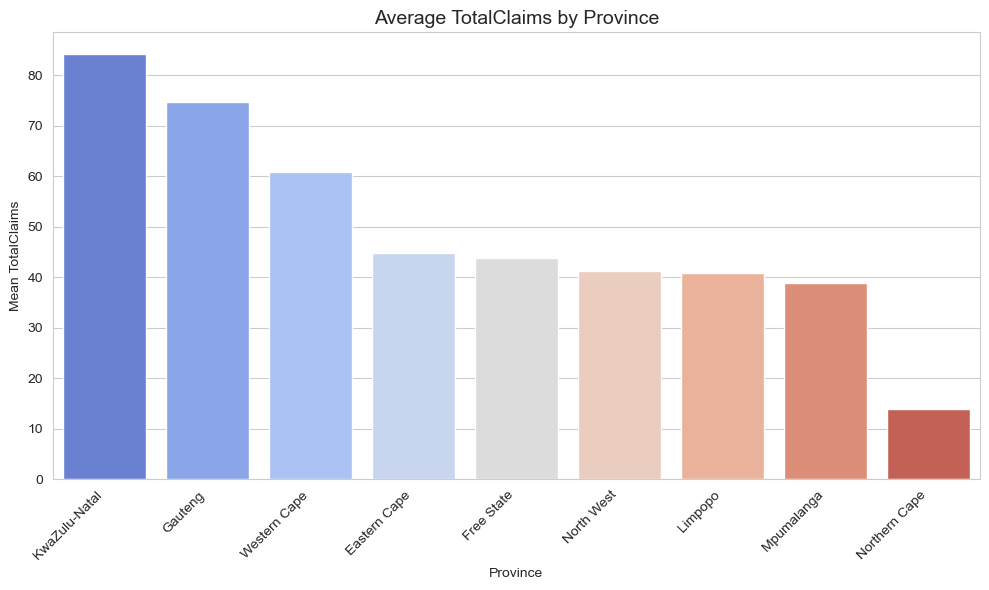

In [7]:
# Columns to compare for mean:
numerical_comparison_cols = ['TotalPremium', 'SumInsured', 'TotalClaims']
analyze_numerical_geography(df_clean, numerical_comparison_cols)

##### Multivariate Risk Check (Advanced)For a powerful summary of regional risk, calculate the Loss Ratio ($\frac{\text{Total Claims}}{\text{Total Premium}}$) for each province and plot it.Low Loss Ratio: High-profit/low-risk region.High Loss Ratio: Low-profit/high-risk region.This directly addresses the business objective of finding "low-risk" targets.


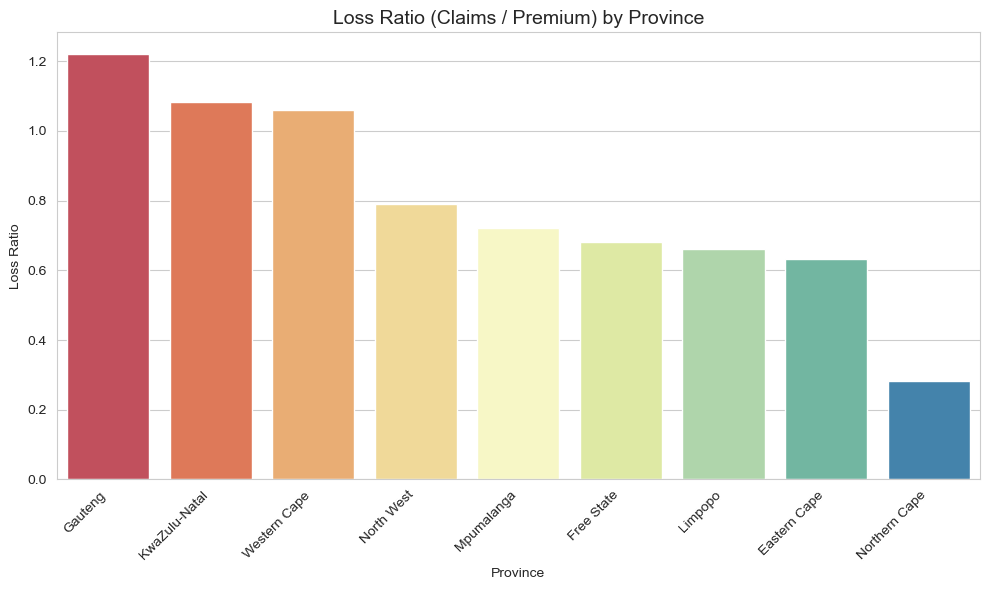

In [9]:
plot_loss_ratio_by_province(df_clean)

#### Code Implementation: Outlier Detection

In [9]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000098 entries, 0 to 1000097
Data columns (total 52 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   UnderwrittenCoverID       1000098 non-null  int64  
 1   PolicyID                  1000098 non-null  int64  
 2   TransactionMonth          1000098 non-null  object 
 3   IsVATRegistered           1000098 non-null  bool   
 4   Citizenship               1000098 non-null  object 
 5   LegalType                 1000098 non-null  object 
 6   Title                     1000098 non-null  object 
 7   Language                  1000098 non-null  object 
 8   Bank                      854137 non-null   object 
 9   AccountType               959866 non-null   object 
 10  MaritalStatus             991839 non-null   object 
 11  Gender                    990562 non-null   object 
 12  Country                   1000098 non-null  object 
 13  Province                  1


## 🔎 Outlier Detection: Individual Box Plots (Minimized & Gridless)


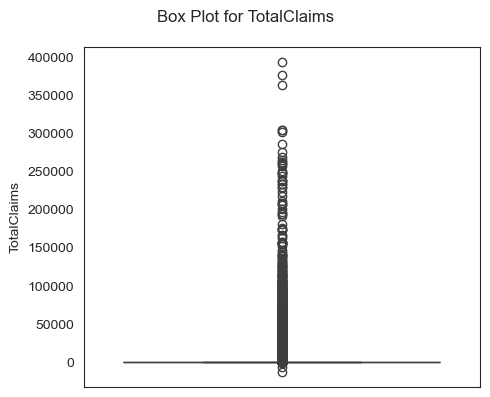

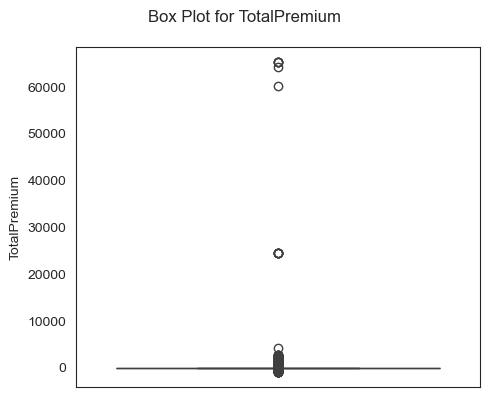

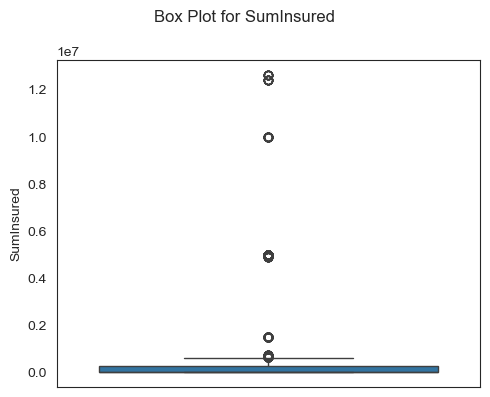

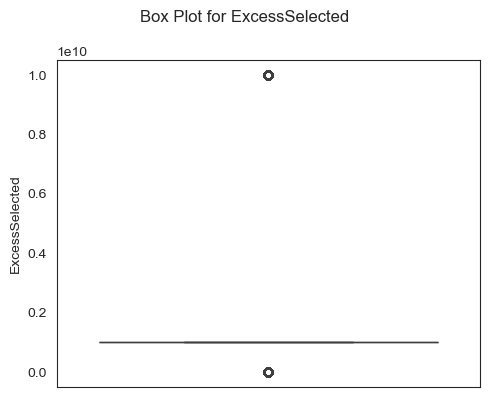

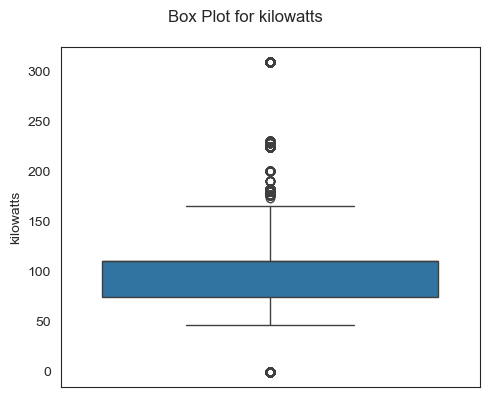

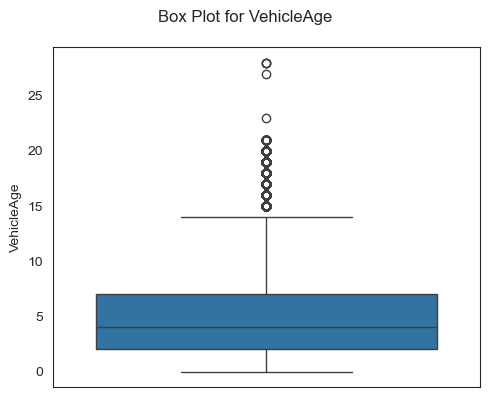

In [6]:
# Example Usage (assuming you have a list of numerical features):
numerical_cols = ['TotalClaims', 'TotalPremium', 'SumInsured', 'ExcessSelected', 'kilowatts', 'VehicleAge']
plot_box_plots_for_outliers_separate(df_clean, numerical_cols)